In [1]:
import numpy as np
import terra

from meerkat.contrib.eeg import build_stanford_eeg_dp

from domino.emb.eeg import generate_words_dp, embed_words, embed_eeg
from domino.evaluate import run_sdms, score_sdm_explanations, score_sdms, run_sdm
from domino.sdm import MixtureModelSDM, SpotlightSDM
from domino.slices import collect_settings
from domino.train import score_settings, synthetic_score_settings, train_settings
from domino.utils import split_dp, balance_dp

import meerkat as mk
import seaborn as sns
import matplotlib.pyplot as plt


/home/ksaab/Documents/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [2]:
setting_dp = collect_settings.out(load=True)
setting_dp

,alpha (NumpyArrayColumn),build_setting_kwargs (ListColumn),dataset (PandasSeriesColumn),slice_category (PandasSeriesColumn),slice_names (ListColumn),target_name (PandasSeriesColumn),index (PandasSeriesColumn),setting_id (PandasSeriesColumn)
0,0.001000,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.001, 'n': 8000}",eeg,rare,['age<1'],sz,0,270cd912-3c73-402a-87a7-59989be1b224
1,0.004729,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.004728708045015879, 'n': 8000}",eeg,rare,['age<1'],sz,1,54a98da9-92a3-462a-b743-b16058cdfeee
2,0.022361,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.022360679774997897, 'n': 8000}",eeg,rare,['age<1'],sz,2,e81dca59-878f-437e-8ddf-206cdd942a9c
3,0.105737,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.1057371263440564, 'n': 8000}",eeg,rare,['age<1'],sz,3,b9620ae6-de51-4d6f-8a6b-b2910f927744
4,0.500000,"{'attribute': 'age', 'attribute_thresh': 1, 'slice_frac': 0.5, 'n': 8000}",eeg,rare,['age<1'],sz,4,5658c026-0e0d-4c09-928d-b1f7c472dec8


In [3]:
run_sdms_dp = run_sdms.out(load=True)
run_sdms_dp.head()

,score_model_run_id (NumpyArrayColumn),setting_id (PandasSeriesColumn),build_setting_run_id (NumpyArrayColumn),score_settings_run_id (NumpyArrayColumn),synthetic_preds (NumpyArrayColumn),index (PandasSeriesColumn),build_setting_kwargs (ListColumn),alpha (NumpyArrayColumn),slice_names (ListColumn),slice_category (PandasSeriesColumn),target_name (PandasSeriesColumn),dataset (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),emb_group (PandasSeriesColumn),time_this_iter_s (PandasSeriesColumn),done (PandasSeriesColumn),timesteps_total (PandasSeriesColumn),episodes_total (PandasSeriesColumn),training_iteration (PandasSeriesColumn),experiment_id (PandasSeriesColumn),date (PandasSeriesColumn),timestamp (PandasSeriesColumn),time_total_s (PandasSeriesColumn),pid (PandasSeriesColumn),hostname (PandasSeriesColumn),node_ip (PandasSeriesColumn),time_since_restore (PandasSeriesColumn),timesteps_since_restore (PandasSeriesColumn),iterations_since_restore (PandasSeriesColumn),trial_id (PandasSeriesColumn),sdm_config/weight_y_log_likelihood (PandasSeriesColumn),sdm_config/n_slices (PandasSeriesColumn),sdm_config/n_clusters (PandasSeriesColumn),sdm_config/emb (PandasSeriesColumn),config/sdm (PandasSeriesColumn),config/slice (PandasSeriesColumn),logdir (PandasSeriesColumn),sdm_class (PandasSeriesColumn)
0,1701,d85b372a-bd06-4512-a1e3-c20708cc3bd9,1701,1700,True,0,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",0.0,"['sz=0_age>1', 'sz=1_age<1']",correlation,sz,eeg,1716,eeg,1.904885,False,NaN,NaN,1,c81a3d6ec1a14b2ea30a3ca15775b426,2021-09-29_10-26-25,1632936385,1.904885,13585,gemini1,171.65.28.88,1.904885,0,1,57a4c_00000,10,10,10,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['eeg', 'emb'], 'n_clusters': 10, 'n_slices': 10, 'weight_y_log_likelihood': 10}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'n': 8000, 'slice_frac': None}, 'build_setting_run_id': 1701, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 1701, 'score_settings_run_id': 1700, 'setting_id': 'd85b372a-bd06-4512-a1e3-c20708cc3bd9', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'True', 'target_name': 'sz'}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/1711/_evaluate_2021-09-29_10-26-12/_evaluate_57a4c_00000_0_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 10, _2021-09-29_10-26-12",domino.sdm.gmm.MixtureModelSDM
1,1701,d85b372a-bd06-4512-a1e3-c20708cc3bd9,1701,1700,True,1,"{'correlate': 'age', 'corr': 0.0, 'correlate_threshold': 1, 'n': 8000}",0.0,"['sz=0_age>1', 'sz=1_age<1']",correlation,sz,eeg,1715,multimodal,1.723058,False,NaN,NaN,1,fc74c377b1ef4a4ba8437f73b46fbe5f,2021-09-29_10-26-25,1632936385,1.723058,13588,gemini1,171.65.28.88,1.723058,0,1,57a4c_00001,10,10,10,emb,"{'sdm_class': '', 'sdm_config': {'emb': ['multimodal', 'emb'], 'n_clusters': 10, 'n_slices': 10, 'weight_y_log_likelihood': 10}}","{'alpha': 0.0, 'build_setting_kwargs': {'attribute': None, 'attribute_thresh': None, 'corr': 0.0, 'correlate': 'age', 'correlate_threshold': 1.0, 'n': 8000, 'slice_frac': None}, 'build_setting_run_id': 1701, 'dataset': 'eeg', 'index': '0', 'score_model_run_id': 1701, 'score_settings_run_id': 1700, 'setting_id': 'd85b372a-bd06-4512-a1e3-c20708cc3bd9', 'slice_category': 'correlation', 'slice_names': ['sz=0_age>1', 'sz=1_age<1'], 'synthetic_preds': 'True', 'target_name': 'sz'}","/media/4tb_hdd/terra/slice/tasks/evaluate/run_sdms/_runs/1711/_evaluate_2021-09-29_10-26-12/_evaluate_57a4c_00001_1_sdm={'sdm_class': , 'sdm_config': {'weight_y_log_likelihood': 10, _2021-09-29_10-26-12",domino.sdm.gmm.MixtureModelSDM
2,1702,698797c0-b6a3-401d-8f4f-28f9964ea167,1702,1700,True,2,"{'correlate': 'age', 'corr': 0.2, 'correlate_threshold': 1, 'n': 8000}",0.2,"['sz=0_age>1', 'sz=1_age<1']",correlation,sz,eeg,1718,eeg,1.712970,False,NaN,NaN,1,8cc4187743b8408c8b29477d97fb4b26,2021-09-29_10-26-

In [4]:
score_dp = mk.DataPanel.from_pandas(score_sdms.out(load=True))
score_dp

,pred_slice_idx (PandasSeriesColumn),slice_idx (PandasSeriesColumn),auroc (PandasSeriesColumn),precision_at_10 (PandasSeriesColumn),precision_at_25 (PandasSeriesColumn),precision_at_100 (PandasSeriesColumn),recall_at_50 (PandasSeriesColumn),recall_at_100 (PandasSeriesColumn),recall_at_200 (PandasSeriesColumn),recall (PandasSeriesColumn),precision (PandasSeriesColumn),target_name (PandasSeriesColumn),run_sdm_run_id (PandasSeriesColumn),slice_name (PandasSeriesColumn),index (PandasSeriesColumn)
0,0.0,0.0,0.168817,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,1716.0,sz=0_age>1,0
1,1.0,0.0,0.829341,0.4,0.48,0.64,0.167421,0.289593,0.574661,0.348416,0.626016,sz,1716.0,sz=0_age>1,1
2,2.0,0.0,0.078945,0.0,0.00,0.00,0.000000,0.000000,0.009050,0.009050,0.006623,sz,1716.0,sz=0_age>1,2
3,3.0,0.0,0.858428,0.4,0.48,0.46,0.108597,0.208145,0.438914,0.217195,0.444444,sz,1716.0,sz=0_age>1,3
4,4.0,0.0,0.854230,0.2,0.20,0.36,0.135747,0.162896,0.339367,0.176471,0.354545,sz,1716.0,sz=0_age>1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,5.0,0.0,0.537635,0.3,0.40,0.45,0.037162,0.076014,0.152027,0.104730,0.427586,sz,1731.0,age<1,295
296,6.0,0.0,0.591314,0.6,0.32,0.42,0.000000,0.070946,0.170608,0.111486,0.474820,sz,1731.0,age<1,296
297,7.0,0.0,0.409390,0.6,0.40,0.42,0.057432,0.070946,0.128378,0.089527,0.441667,sz,1731.0,age<1,297
298,8.0,0.0,0.382834,0.5,0.48,0.30,0.000000,0.000000,0.106419,0.153716,0.338290,sz,1731.0,age<1,298


In [7]:
results_dp = mk.merge(
    score_dp,
    run_sdms_dp["config/sdm", "alpha", "run_sdm_run_id", "build_setting_kwargs"], # include any other columns here you'd like to analyze
    on="run_sdm_run_id"
)
emb_col = results_dp["config/sdm"].map(lambda x: x["sdm_config"]["emb"][0])
results_dp["emb_type"] = emb_col

corr_thresh_col = results_dp["build_setting_kwargs"].map(lambda x: x["correlate_threshold"] if "correlate_threshold" in x else x["attribute_thresh"])
results_dp["corr_thresh"] = corr_thresh_col


results_df = results_dp.to_pandas()
results_df

,run_sdm_run_id,pred_slice_idx,slice_idx,auroc,precision_at_10,precision_at_25,precision_at_100,recall_at_50,recall_at_100,recall_at_200,recall,precision,target_name,slice_name,index,config/sdm,alpha,build_setting_kwargs,emb_type,corr_thresh
0,1716,0,0,0.168817,0.0,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,sz,sz=0_age>1,0,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",eeg,1
1,1716,1,0,0.829341,0.4,0.48,0.64,0.167421,0.289593,0.574661,0.348416,0.626016,sz,sz=0_age>1,1,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",eeg,1
2,1716,2,0,0.078945,0.0,0.00,0.00,0.000000,0.000000,0.009050,0.009050,0.006623,sz,sz=0_age>1,2,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",eeg,1
3,1716,3,0,0.858428,0.4,0.48,0.46,0.108597,0.208145,0.438914,0.217195,0.444444,sz,sz=0_age>1,3,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",eeg,1
4,1716,4,0,0.854230,0.2,0.20,0.36,0.135747,0.162896,0.339367,0.176471,0.354545,sz,sz=0_age>1,4,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.0,"{'correlate': 'age', 'corr': 0.0, 'correlate_t...",eeg,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,1731,5,0,0.537635,0.3,0.40,0.45,0.037162,0.076014,0.152027,0.104730,0.427586,sz,age<1,295,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.5,"{'attribute': 'age', 'attribute_thresh': 1, 's...",multimodal,1
296,1731,6,0,0.591314,0.6,0.32,0.42,0.000000,0.070946,0.170608,0.111486,0.474820,sz,age<1,296,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.5,"{'attribute': 'age', 'attribute_thresh': 1, 's...",multimodal,1
297,1731,7,0,0.409390,0.6,0.40,0.42,0.057432,0.070946,0.128378,0.089527,0.441667,sz,age<1,297,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.5,"{'attribute': 'age', 'attribute_thresh': 1, 's...",multimodal,1
298,1731,8,0,0.382834,0.5,0.48,0.30,0.000000,0.000000,0.106419,0.153716,0.338290,sz,age<1,298,{'sdm_class': '<class 'domino.sdm.gmm.MixtureM...,0.5,"{'attribute': 'age', 'attribute_thresh': 1, 's...",multimodal,1


30


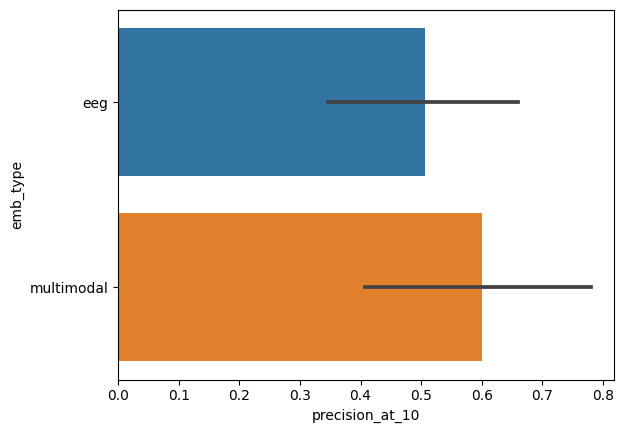

In [12]:
metric = "precision_at_10"
grouped_df = results_df.iloc[results_df.reset_index().groupby(["slice_name", "slice_idx","emb_type","alpha", "corr_thresh"])[metric].idxmax().astype(int)]

print(len(grouped_df))
#ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
ax = sns.barplot(data=grouped_df,x=metric,y="emb_type")
plt.show()

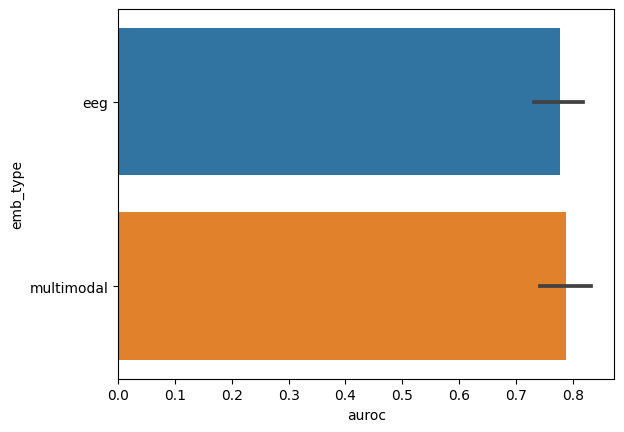

In [9]:
metric = "auroc"
grouped_df = results_df.iloc[results_df.reset_index().groupby(["slice_name", "slice_idx","emb_type","alpha","corr_thresh"])[metric].idxmax().astype(int)]


#ax = sns.lineplot(data=grouped_df,x="alpha",y=metric, hue="emb_type",style="slice_name")
ax = sns.barplot(data=grouped_df,x=metric,y="emb_type")
plt.show()

<ipython-input-11-3f7f700a2761>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df["success"] = np.logical_and(grouped_df["auroc"] > 0.7, grouped_df["precision_at_10"] > 0.4)


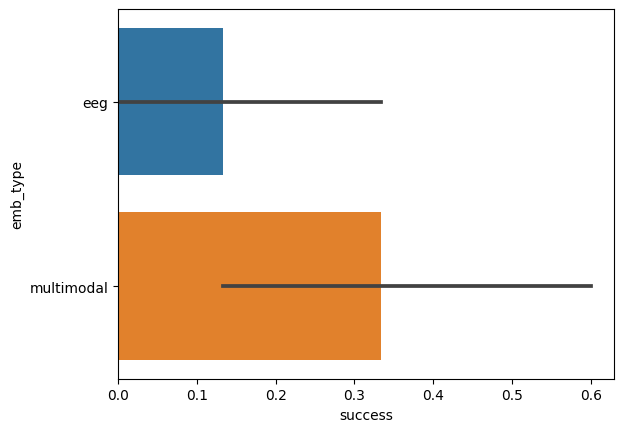

In [11]:
grouped_df["success"] = np.logical_and(grouped_df["auroc"] > 0.7, grouped_df["precision_at_10"] > 0.4)

#ax = sns.pointplot(data=grouped_df,x="alpha",y="success", hue="emb_type", dodge=True, join=False)
ax = sns.barplot(data=grouped_df,x="success",y="emb_type")

plt.show()

# Explanations

In [ ]:
words_dp = embed_words.out(load=True)

# get multimodal sdm run ids
slice_id = 0
alpha = 0.8

specific_run = grouped_df[grouped_df["emb_type"]=="multimodal"][grouped_df["slice_idx"]==slice_id][grouped_df["alpha"]==alpha]
specific_run

In [ ]:
pred_slice_idx = specific_run["pred_slice_idx"].values[0]
_, expl_dp = run_sdm.out(specific_run["run_sdm_run_id"].values[0],load=True)
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][:10]

In [ ]:
expl_dp[(-expl_dp["pred_slices"].data[:,pred_slice_idx]).argsort()][10:20]